Read folder files, re-reference channel 8, add uniform time distribution, store channels 7-8 data and stimuli appearance
====================================

In [129]:
%matplotlib inline
from collections import OrderedDict
import pandas as pd
import numpy as np
from scipy.fftpack import rfft, irfft
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import math
path = 'data/'  # data path
files = [f for f in listdir(path) if isfile(join(path, f))]  # get all files of the directory path
cols = ['Time','Ch-7','Ch-8','Key','Freq']  # define colums to select
channels = ['Ch-7','Ch-8']  # define channels to select
df_all = []  # contain all dataframes of all files for AVG
df_sall = []  # same but for stimuli appearance
resolution = 4.5 # assuming each datapoint is recorded every 4.5ms
# color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']  # color codes to plot
color = ['c', 'm', 'y', 'k', 'w']  # color codes to plot
font = {'weight': 'bold', 'size': 25}  # font to plot
stimulus_length = 500  # 0.5 seconds
freq_filter_max = 100  # high-pass filter
freq_filter_min = 20  # low-pass filter
max_time = 112000.5  # max time of a trial -> 112 seconds in ms distributed over 4.5ms
size = 24890  # number of rows distributing all datapoints each 4.5 ms in 112000.5 ms
sampling_rate = 223  # 223 Hz or 223 datapoints per second
x = [resolution * i for i in range(size)]  # generate a regular time series list
N = sampling_rate
# sample spacing
T = 1.0 / N
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)  # frequency range of the spectrum to visualize
# Create a dataframe per file (trial) and store it in a list of dataframes
for i, file in enumerate(files):
    print("Trial " + str(i) + ": " + file)  # print the current filename (trial) info
    filename = path + file
    curr = pd.read_csv(filename, skiprows=3, usecols=cols, index_col=False)  # read the current file
    curr['Ch-7'] *= -1  # Re-reference channel 7 as polarity from Fpz is inverted in respect of left channel
    curr['RTime'] = curr['Time']  # store the Bluetooth-delayed datapoint time as another column
    curr = curr.iloc[:size]  # slice the dataset to 24890 rows or 112000.5 ms
    curr['Time'] = x  # set time as a uniform time distribution each 4.5 ms
    # read and store the stimuli presentation times
    curr_s = pd.read_csv(filename, skiprows=2, nrows=1, index_col=False, usecols=range(1, 37), header=None)
    curr_s = curr_s.T  # transpose the series (make it vertical, like a dataframe column)
    curr_s = pd.Series(curr_s[0])  # store stimuli timestamps as a series  
    df_sall.append(curr_s)  # store the current stimuli timestamps series for later averaging  
    df_all.append(curr)  # store the current trial dataframe for later averaging

Trial 0: 05-03-2019_13-25-38_C4-B6_1.csv
Trial 1: 05-03-2019_13-27-57_C4-B6_2.csv
Trial 2: 05-03-2019_13-30-06_C4-B6_3.csv
Trial 3: 05-03-2019_13-32-13_C4-B6_4.csv
Trial 4: 05-03-2019_13-34-35_C4-B6_5.csv


Inspect data, plot all trials from all channels
==

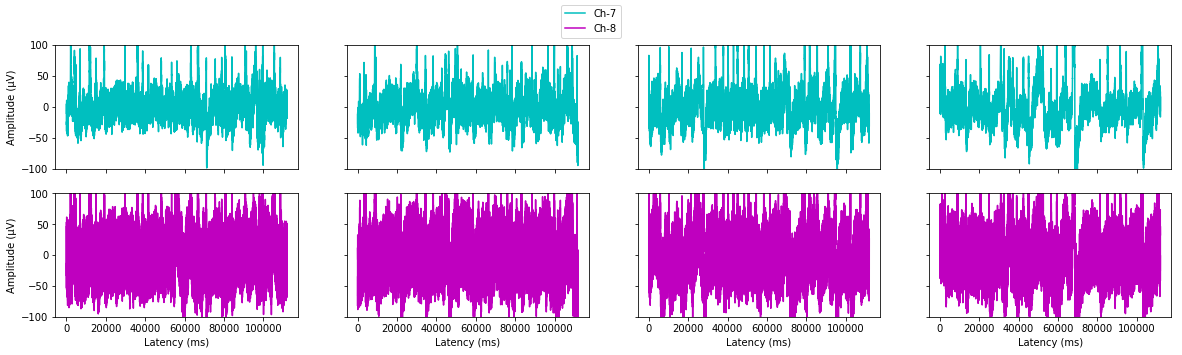

In [29]:
fig, ax = plt.subplots(nrows=len(channels), ncols=len(files), figsize=(20, 5), sharex='all', sharey='all')  # define subplot matrix from nchanels and nfiles
ax[0, 0].set_ylim([-100, 100])
legend_L = []
# Whole trial plots
for row, ch in enumerate(channels): 
    for col, data in enumerate(df_all):
        y = data[ch]  # set voltage values as y
        pl = ax[row][col].plot(x, y, color=color[row], label=ch)  # plot the dataframe
        if col == 0:
            ax[row][col].set_ylabel('Amplitude (μV)')
        if row == 1:
            ax[row][col].set_xlabel('Latency (ms)')
    legend_L.append(pl[0])
fig.legend(legend_L, channels, loc = 'upper center')
#         for timestamp in df_sall[col]:  # plot the stimuli start (green) and stop (red) as vertical lines
#             ax[row][col].axvline(x=timestamp, color='green', linestyle='--', label='Stimuli Start')
#             ax[row][col].axvline(x=timestamp+stimulus_length, color='red', linestyle='--', label='Stimuli Stop')
#         ax = plt.gca()
#         ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
#         ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)
#         ax[row][col].title(ch, fontdict=font, y=1.15)  # set the plot title
#         ax[row][col].grid(True)  # enable the plot grid


Trials: statistical data
===

In [27]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('descriptive_statistics.xlsx', engine='xlsxwriter')
srow = 0
scol = 0
headers = True
for i, ch in enumerate(channels):
    for j, data in enumerate(df_all):
        data[ch].describe().to_excel(writer, sheet_name='Sheet1', float_format="%.3f", startrow=srow, startcol=scol, index=headers)
        if (srow == 0 or srow == 10) and headers:
            scol += 2
        else:
            scol += 1
        headers = False
    headers = True
    scol = 0
    srow += 10   
writer.save()

EPOCHS:  {'Ch-7': 180, 'Ch-8': 180}
Ch-7: std=0.6537125529681765 mean=-0.28381342927525244
Ch-8: std=2.718610314356941 mean=-2.51083387855303


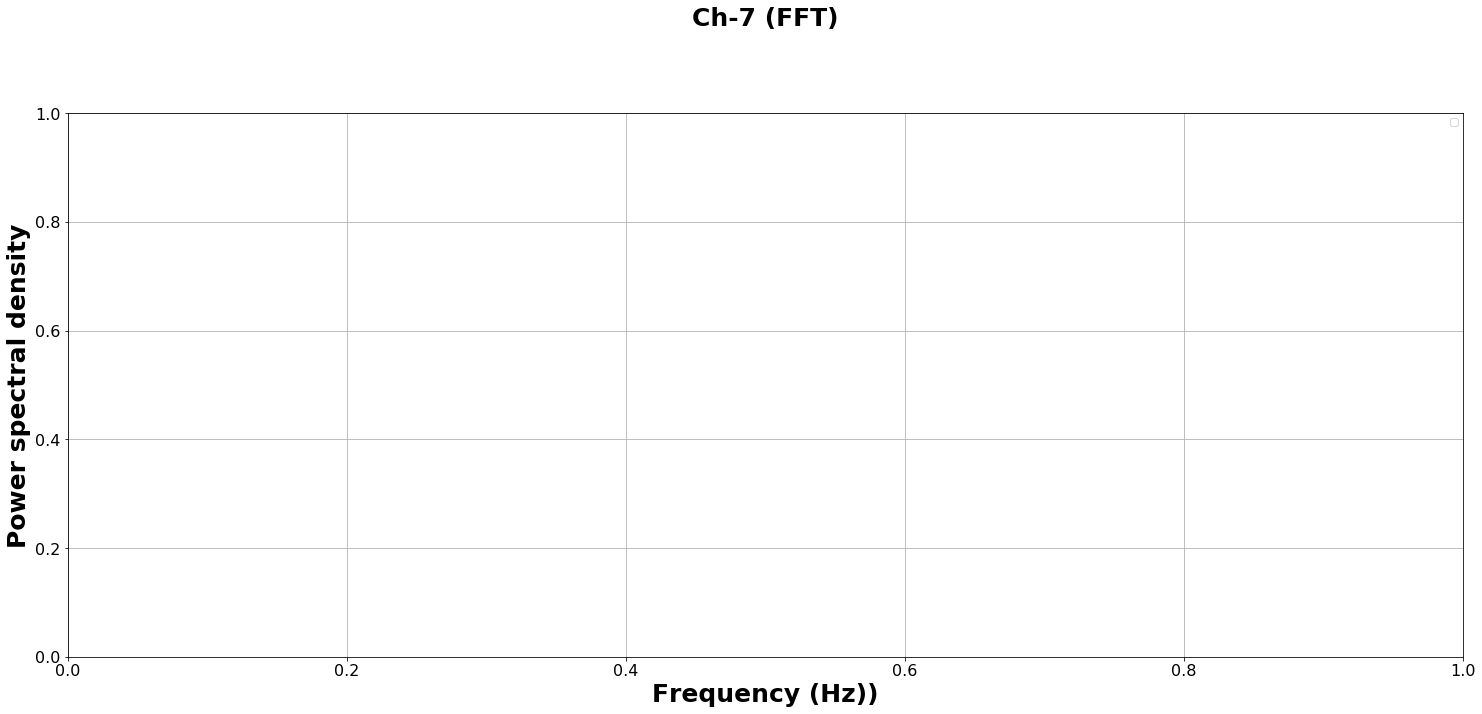

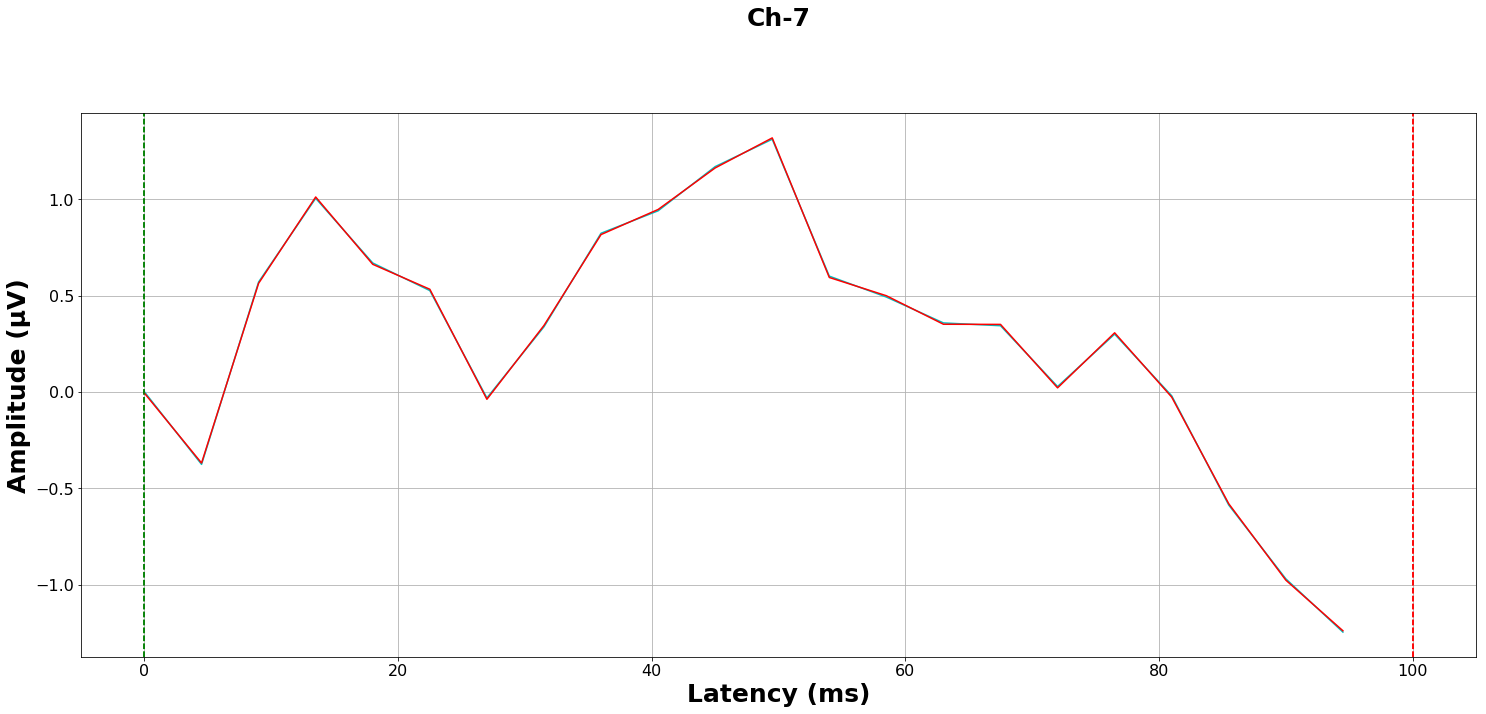

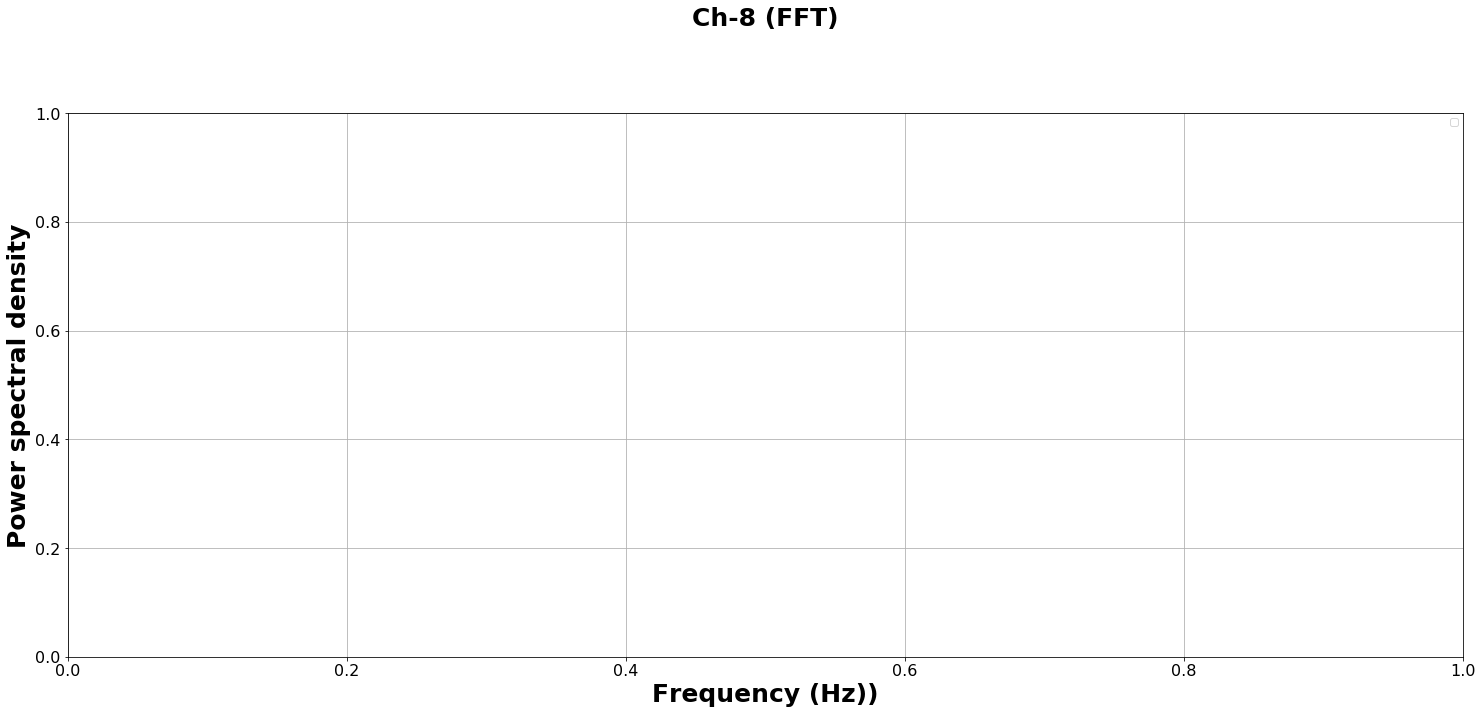

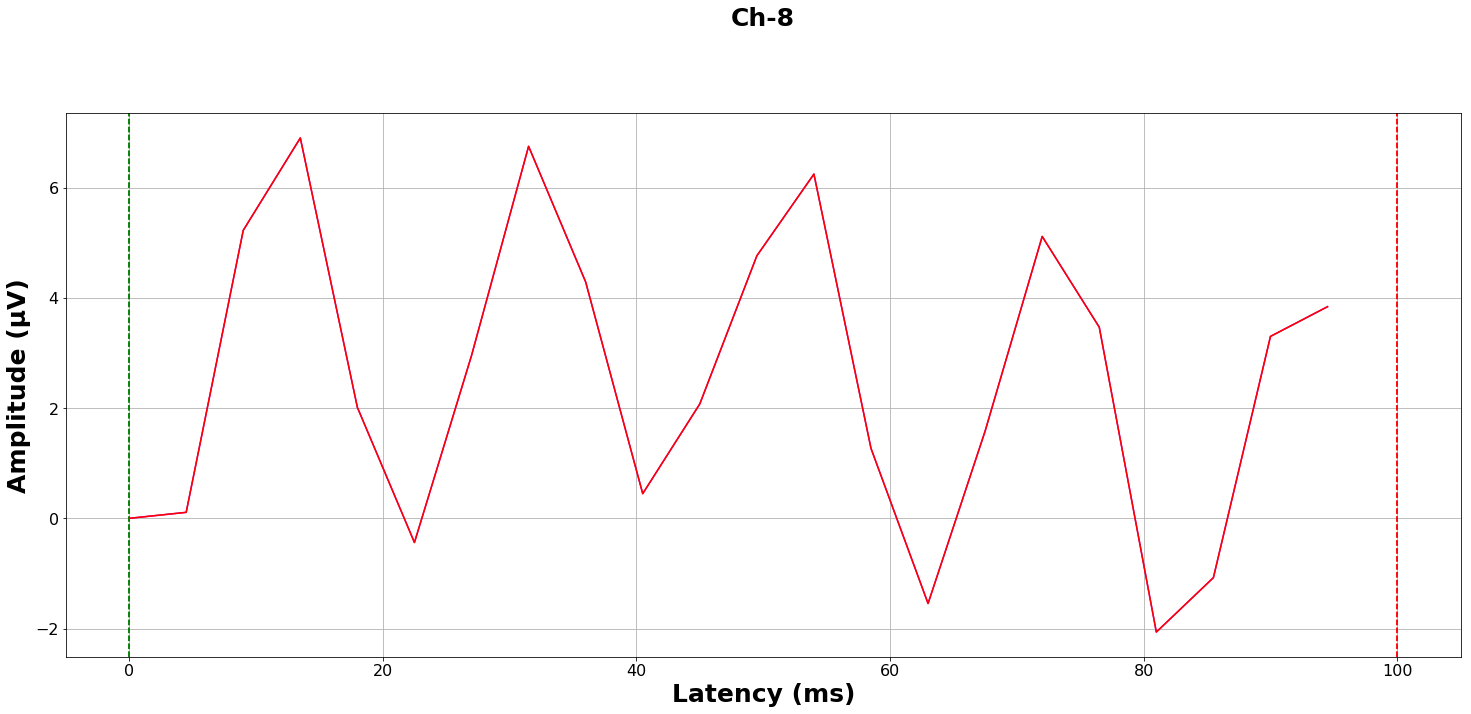

In [130]:
# Epoch indices selection
epochs_indices = []

for s_appearance in df_sall:
    epochs_indices.append(s_appearance)

epochs_indices = [[] for value in df_sall]  # create a list of lists with same length as df_sall
offset_R = 100  # 100ms for selecting AMLR epochs and 500 for ALRs
# set a limit of indices to select to have the same number of datapoints in all epochs
if offset_R == 100:
    indices_limit = 22
if offset_R == 500:
    indices_limit = 111
for index, timestamps_set in enumerate(df_sall):
    for timestamp in df_sall[index]:
        condition = (df_all[index]['Time'] >= timestamp) & (df_all[index]['Time'] <= timestamp + offset_R)
        indices = df_all[index].index[condition].tolist()
        if len(indices) > indices_limit:  # remove the last index value if bigger than limit
            indices.pop()
        epochs_indices[index].append(indices)  # store indices

baseline_diff = 44  # as we want to extract the mean of the 200ms before the stimulus onset (200 / 4.5 = 44.44)
# Baseline correction on each epoch
for i, epoch_set in enumerate(epochs_indices):
    for epoch in epoch_set:
        pre_epoch = [epoch[0] - i - 1 for i in range(baseline_diff)]
        pre_epoch.reverse()
        for ch in channels:
            # select stimulus on-set first voltage value
            correction = df_all[i].loc[pre_epoch, ch].mean()
            df_all[i].loc[epoch, ch] -= correction
            df_all[i].loc[epoch, ch] -= df_all[i].loc[epoch, ch].values[0]
n_epochs = {}
# Epoch averaging: average the voltage amplitude of all epochs of all trials per channel
df_avg = df_all[0].loc[epochs_indices[0][0]]  # select the first epoch of the first trial
for ch in channels:
    df_avg[ch] -= df_avg[ch]  # set values to 0 to calculate the average
    n_epochs[ch] = 0
df_avg.reset_index(drop=True, inplace=True)

for i, epoch_set in enumerate(epochs_indices):
    for epoch in epoch_set:
        pre_epoch = [epoch[0] - i - 1 for i in range(baseline_diff)]
        pre_epoch.reverse()
        for ch in channels: 
            selected = df_all[i].loc[epoch, ch]
            selected.reset_index(drop=True, inplace=True)
            signal = np.sqrt(np.mean(selected**2))
            pre = df_all[i].loc[pre_epoch, ch]
            noise = np.sqrt(np.mean(pre**2))
            snr = 20*math.log10(signal / noise) # maybe ((signal - noise) / noise)**2
#                 if abs(snr) > snr_ratio:
#             if selected.max() < 45 and selected.min() > -45:
            df_avg[ch] += selected
            n_epochs[ch] += 1
print("EPOCHS: ", n_epochs)
#     df_avg['Ch-7'] /= n_epochs['Ch-7']
for ch in channels:
    df_avg[ch] /= n_epochs[ch]
df_avg = df_avg.dropna()  # remove NaNs if any

# recalculate time for the averaged epochs
x = [resolution * i for i in range(df_avg.shape[0])]  # time
for i, ch in enumerate(channels):
#         if ch != 'Ch-8':
    print(ch + ": std=" + str(df_avg[ch].std()) + " mean=" + str(df_avg[ch].mean()))
#     y = (df_selected[ch] - df_selected[ch].min()) / (df_selected[ch].max() - df_selected[ch].min())
    y = df_avg[ch] * -1
    yf = rfft(y)  # apply Discrete Fourier Transform of a real sequence (voltage amplitude) 
    # Frequency spectrum
    plt.figure(figsize=(25, 10))  # set the figure size
#     plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color=color[i], label=ch)  # plot the frequency 
    plt.xlabel('Frequency (Hz))', fontdict=font)  # set the x-axis label
    plt.ylabel('Power spectral density', fontdict=font)  # set the y-axis label
    ax = plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)
    plt.title(ch + ' (FFT)', fontdict=font, y=1.15)  # set the plot title
    plt.grid(True)  # enable the plot grid
    plt.legend(channels)  # set the plot legend
    plt.figure(figsize=(25, 10))
#     plt.ylim(-2, 2)
    plt.plot(x, y, color=color[i])
    plt.axvline(x=0, color='g', linestyle='--', label='Stimuli Start')
    plt.axvline(x=0+offset_R, color='r', linestyle='--', label='Stimuli Stop')
    plt.title(ch, fontdict=font, y=1.15)
    plt.grid(True)
# TODO: Apply the right filters, check AMLR (100ms) and ALR
# Apply band-pass filters 
    for f in range(len(yf)):
        if f > 20:
            yf[f] = 0
#                 if f > 0 and f < 1:
#                     yf[f] = 0
#         if f > 40 and f < 51:
#             yf[f] = 0
    filtered = irfft(yf, n=None, axis=-1, overwrite_x=False)  # store the filtered signal
    xfil = [resolution * j for j in range(filtered.shape[0])]
    plt.plot(xfil, filtered, color='r')
    plt.axvline(x=0, color='g', linestyle='--', label='Stimuli Start')
    plt.axvline(x=0+offset_R, color='r', linestyle='--', label='Stimuli Stop')
    ax = plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)
    plt.xlabel('Latency (ms)', fontdict=font)  # set the x-axis label
    plt.ylabel('Amplitude (μV)', fontdict=font)  # set the y-axis label
    plt.title(ch, fontdict=font, y=1.15)
    plt.grid(True)
plt.show()